## Feature Engineering EDA For Dengue Competition

Since feature engineering plays such a huge role in this competition, this pipeline is used to see which features contribute to an improving score and which ones do not.

The following notebook is to explore the following:

* Rolling Features (testing different rolling windows on performance)
* Exponential Weighted Averaging (different spans)
* Automatic Feature Generation (with TSFresh)
* Feature Selection (removing zero variance features, etc.)

In [21]:
import seaborn as sns
# sns.set_theme("poster")

import pandas as pd
pd.options.display.max_columns = 200
pd.options.display.max_rows = 200

import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [14, 12] 

In [50]:
path = "../dengue_data/"

X_train = pd.read_csv(path + "dengue_features_train.csv")
y_train = pd.read_csv(path + "dengue_labels_train.csv")
X_test = pd.read_csv(path +  "dengue_features_test.csv")

full_train = X_train.copy()
full_train['total_cases'] = y_train['total_cases']

submission_format = pd.read_csv(path + "/submission_format.csv")

Text(0.5, 1.0, 'Total Cases')

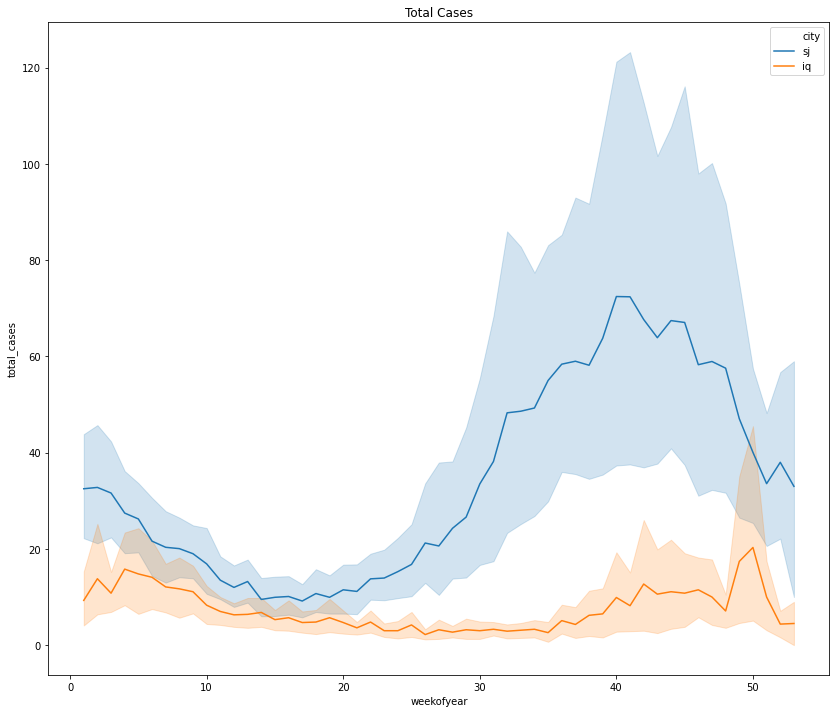

In [52]:
sns.lineplot(x = "weekofyear", y = "total_cases", hue = "city", data = full_train).set_title("Total Cases")

## Load and quick looks

In [23]:
X_train.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [24]:
y_train.head()

,city,year,weekofyear,total_cases
0,sj,1990,18,4
1,sj,1990,19,5
2,sj,1990,20,4
3,sj,1990,21,3
4,sj,1990,22,6


In [25]:
submission_format.head()

,city,year,weekofyear,total_cases
0,sj,2008,18,0
1,sj,2008,19,0
2,sj,2008,20,0
3,sj,2008,21,0
4,sj,2008,22,0


In [26]:
submission_format.city.value_counts()

sj    260
iq    156
Name: city, dtype: int64

In [27]:
X_test.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,2008,18,2008-04-29,-0.0189,-0.018900,0.102729,0.091200,78.60,298.492857,298.550000,294.527143,301.1,296.4,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
1,sj,2008,19,2008-05-06,-0.0180,-0.012400,0.082043,0.072314,12.56,298.475714,298.557143,294.395714,300.8,296.7,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2,sj,2008,20,2008-05-13,-0.0015,NaN,0.151083,0.091529,3.66,299.455714,299.357143,295.308571,302.2,296.4,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
3,sj,2008,21,2008-05-20,NaN,-0.019867,0.124329,0.125686,0.00,299.690000,299.728571,294.402857,303.0,296.9,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3
4,sj,2008,22,2008-05-27,0.0568,0.039833,0.062267,0.075914,0.76,299.780000,299.671429,294.760000,302.3,297.3,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1


## Statistical Summary

In [54]:
# full_train.groupby("city").describe()

In [56]:
bycity_byweek_stats = full_train.groupby(["city", "weekofyear"]).describe()
bycity_byweek_stats.head()
# bycity_byweek_stats.to_csv("../deng_eda/bycity_byweek_stats.csv")  # Save

year                                                     \
                count    mean      std     min      25%     50%      75%   
city weekofyear                                                            
iq   1           10.0  2005.5  3.02765  2001.0  2003.25  2005.5  2007.75   
     2           10.0  2005.5  3.02765  2001.0  2003.25  2005.5  2007.75   
     3           10.0  2005.5  3.02765  2001.0  2003.25  2005.5  2007.75   
     4           10.0  2005.5  3.02765  2001.0  2003.25  2005.5  2007.75   
     5           10.0  2005.5  3.02765  2001.0  2003.25  2005.5  2007.75   

                        ndvi_ne                                          \
                    max   count      mean       std       min       25%   
city weekofyear                                                           
iq   1           2010.0    10.0  0.238823  0.086418  0.124571  0.193482   
     2           2010.0    10.0  0.289377  0.109922  0.145286  0.228779   
     3           2010.0    10.0  0.246766  0.064571  0.174300  0.188293   
     4           2010.0    10.0  0.232678  0.077953  0.104129  0.189761   
     5           2010.0     9.0  0.237898  0.092811  0.158229  0.166733   

                                              ndvi_nw                      \
                      50%       75%       max   count      mean       std   
city weekofyear                                                             
iq   1           0.211344  0.299811  0.405729    10.0  0.215747  0.064759   
     2           0.275777  0.321791  0.488400    10.0  0.260149  0.099320   
     3           0.246600  0.295225  0.345933    10.0  0.209562  0.073947   
     4           0.231279  0.274296  0.364367    10.0  0.224632  0.073870   
     5           0.174414  0.341500  0.379114     9.0  0.219553  0.079596   

                                                                  ndvi_se  \
                      min       25%       50%       75%       max   count   
city weekofyear                                                             
iq   1           0.155414  0.166046  0.192798  0.236639  0.348400    10.0   
     2           0.122340  0.202433  0.241392  0.348155  0.402443    10.0   
     3           0.103317  0.151604  0.204507  0.277971  0.311800    10.0   
     4           0.137700  0.159063  0.214957  0.273504  0.336529    10.0   
     5           0.140629  0.167250  0.180500  0.260667  0.370571     9.0   

                                                                             \
                     mean       std       min       25%       50%       75%   
city weekofyear                                                               
iq   1           0.240763  0.073521  0.153271  0.179654  0.236107  0.290121   
     2           0.269627  0.103342  0.134300  0.198220  0.264300  0.345825   
     3           0.237119  0.060470  0.111757  0.205289  0.245743  0.287757   
     4           0.204731  0.059817  0.112186  0.161525  0.212900  0.247929   
     5           0.221807  0.084876  0.117914  0.159071  0.191386  0.313800   

                          ndvi_sw                                          \
                      max   count      mean       std       min       25%   
city weekofyear                                                             
iq   1           0.368643    10.0  0.223386  0.087723  0.119443  0.148414   
     2           0.414929    10.0  0.303029  0.105002  0.167529  0.232252   
     3           0.306720    10.0  0.255085  0.066168  0.169971  0.195232   
     4           0.292557    10.0  0.252618  0.065000  0.141914  0.218307   
     5           0.345971     9.0  0.240064  0.109322  0.126600  0.161717   

                                              precipitation_amt_mm            \
                      50%       75%       max                count      mean   
city weekofyear                                                                
iq   1           0.201729  0.282850  0.380014                  8.0  51.56125   
   

In [61]:
# bycity_byweek_stats["ndvi_ne"].unstack(level = 0).head(5).style.background_gradient(cmap=sns.diverging_palette(240, 10, as_cmap=True))

## Indicate "high total cases"

In [31]:
#full_train.groupby("city").total_cases.quantile([0.25, 0.5, 0.75])

In [32]:
# bin_quantiles = pd.qcut(col)
# df.apply(bin_quantiles)

## How many cases were there per city

In [64]:
full_train.groupby("city")["total_cases"].sum()

city
iq     3934
sj    31993
Name: total_cases, dtype: int64

### Label quantiles of total_cases and add to features as semi-supervised or self-supervised learning

In [34]:
full_train[full_train.city == "sj"]

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
931,sj,2008,13,2008-03-25,0.077850,-0.039900,0.310471,0.296243,27.19,296.958571,296.957143,292.095714,299.7,294.4,7.55,74.247143,27.19,13.644286,2.885714,25.042857,5.785714,30.0,21.1,1.8,4
932,sj,2008,14,2008-04-01,-0.038000,-0.016833,0.119371,0.066386,3.82,298.081429,298.228571,293.235714,299.8,296.5,3.67,74.600000,3.82,14.662857,2.714286,26.242857,6.814286,30.6,22.2,0.5,3
933,sj,2008,15,2008-04-08,-0.155200,-0.052750,0.137757,0.141214,16.96,297.460000,297.564286,292.732857,299.4,295.8,35.00,75.027143,16.96,14.184286,2.185714,25.000000,5.714286,29.4,21.7,30.7,1
934,sj,2008,16,2008-04-15,0.001800,NaN,0.203900,0.209843,0.00,297.630000,297.778571,292.274286,299.7,295.9,4.82,72.285714,0.00,13.858571,2.785714,25.314286,6.242857,29.4,21.7,11.2,3


In [35]:
sj_quantile_labels = pd.qcut(full_train[full_train.city == "sj"].total_cases, 5, labels = range(1, 6))
sj_quantile_labels = sj_quantile_labels.rename("quantile")
sj_quantile_labels.to_csv("../deng_features/sj_quantile_labels.csv")

iq_quantile_labels = pd.qcut(full_train[full_train.city == "iq"].total_cases, 5, labels = range(1, 6))
iq_quantile_labels = iq_quantile_labels.rename("quantile")
iq_quantile_labels.to_csv("../deng_features/iq_quantile_labels.csv")

In [36]:
sj_quantile_labels

0      1
1      1
2      1
3      1
4      1
      ..
931    1
932    1
933    1
934    1
935    1
Name: quantile, Length: 936, dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

In [37]:
sj_quantile_dummies = pd.get_dummies(sj_quantile_labels, prefix = "quantile_")
sj_quantile_dummies.head(2)

,quantile__1,quantile__2,quantile__3,quantile__4,quantile__5
0,1,0,0,0,0
1,1,0,0,0,0


In [38]:
iq_quantile_labels

936     1
937     1
938     1
939     1
940     1
       ..
1451    3
1452    4
1453    1
1454    1
1455    3
Name: quantile, Length: 520, dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

In [39]:
iq_quantile_dummies = pd.get_dummies(iq_quantile_labels, prefix = "quantile_")

In [40]:
iq_quantile_dummies

,quantile__1,quantile__2,quantile__3,quantile__4,quantile__5
936,1,0,0,0,0
937,1,0,0,0,0
938,1,0,0,0,0
939,1,0,0,0,0
940,1,0,0,0,0
...,...,...,...,...,...
1451,0,0,1,0,0
1452,0,0,0,1,0
1453,1,0,0,0,0
1454,1,0,0,0,0


In [41]:
all_quantile_labels = pd.concat([sj_quantile_labels, iq_quantile_labels])
all_quantile_labels.to_csv("../deng_features/all_quantile_labels.csv")

all_quantile_labels.shape

(1456,)

In [42]:
all_quantile_dummies = pd.get_dummies(all_quantile_labels, prefix = "quantile_")
all_quantile_dummies

,quantile__1,quantile__2,quantile__3,quantile__4,quantile__5
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
...,...,...,...,...,...
1451,0,0,1,0,0
1452,0,0,0,1,0
1453,1,0,0,0,0
1454,1,0,0,0,0


## Feature Generation EDA

In [66]:
explore_feature = ["precipitation_amt_mm"]

# Quick Preprocessing
X_train_ml = X_train.replace({"sj":0, "iq":1})
X_train_ml = X_train_ml.drop(["year", "weekofyear", "week_start_date"], axis = 1)
X_train_ml.head(2)


,city,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,0,0.1226,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,0,0.1699,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6


#### Rolling Features

In [65]:
roll3 = X_train_ml.rolling(18).std().add_suffix("r20_std").drop("cityr20_std", axis = 1)
roll3 = roll3.dropna(how = "all")
roll3

,ndvi_ner20_std,ndvi_nwr20_std,ndvi_ser20_std,ndvi_swr20_std,precipitation_amt_mmr20_std,reanalysis_air_temp_kr20_std,reanalysis_avg_temp_kr20_std,reanalysis_dew_point_temp_kr20_std,reanalysis_max_air_temp_kr20_std,reanalysis_min_air_temp_kr20_std,reanalysis_precip_amt_kg_per_m2r20_std,reanalysis_relative_humidity_percentr20_std,reanalysis_sat_precip_amt_mmr20_std,reanalysis_specific_humidity_g_per_kgr20_std,reanalysis_tdtr_kr20_std,station_avg_temp_cr20_std,station_diur_temp_rng_cr20_std,station_max_temp_cr20_std,station_min_temp_cr20_std,station_precip_mmr20_std
17,NaN,0.073186,0.062635,0.065089,35.860641,0.725029,0.693233,1.127835,0.850067,0.811861,19.496123,2.465882,35.860641,1.107802,0.343251,0.845101,0.743270,1.338336,1.036712,17.357080
18,NaN,0.072088,0.064828,0.065128,35.483000,0.589977,0.568121,0.720629,0.831410,0.668625,19.509552,1.875389,35.483000,0.740730,0.443527,0.602366,0.751968,1.017639,0.711645,17.403279
19,NaN,0.095453,0.067315,0.065469,35.998498,0.519573,0.522291,0.533887,0.812323,0.611545,19.262429,1.629000,35.998498,0.579833,0.466970,0.529509,0.757910,0.972850,0.717681,17.056945
20,NaN,0.095409,0.066438,0.069035,43.843023,0.455805,0.460810,0.491399,0.718022,0.604774,19.158687,1.621088,43.843023,0.540535,0.485566,0.398918,0.762809,0.946286,0.716929,17.081382
21,NaN,0.096061,0.066554,0.069233,43.306173,0.422335,0.452963,0.428683,0.694422,0.584579,19.006192,1.898484,43.306173,0.475143,0.484080,0.356536,0.756663,0.951710,0.754789,16.590536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,0.062823,0.053999,0.064029,0.080803,34.801908,0.640547,0.838077,1.148426,1.494008,1.266770,75.298492,4.813560,34.801908,1.229822,1.429523,0.962402,1.272801,1.039230,0.721767,NaN
1452,0.065177,0.057040,0.067524,0.080991,30.108715,0.639474,0.844065,1.151631,1.501688,1.381164,77.708272,4.815964,30.108715,1.233999,1.433789,0.969106,1.272770,1.028420,0.696114,NaN
1453,0.063257,0.056672,0.062504,0.076345,29.915320,0.794767,0.992055,1.210303,1.539088,1.395476,79.190710,4.801693,29.915320,1.306386,1.438038,1.274384,1.505934,1.178844,0.885836,NaN
1454,0.067120,0.055565,0.061218,0.077982,29.638426,0.942324,1.120750,1.264217,1.543826,1.427977,78.787027,4.738694,29.638426,1.373567,1.376464,1.375758,1.474462,1.389550,0.810813,NaN


In [45]:
roll7 = X_train_ml.rolling(7).max().add_suffix("r7_max").drop("cityr7_max", axis = 1)
roll7 = roll7.dropna(how = "all")
roll7

,ndvi_ner7_max,ndvi_nwr7_max,ndvi_ser7_max,ndvi_swr7_max,precipitation_amt_mmr7_max,reanalysis_air_temp_kr7_max,reanalysis_avg_temp_kr7_max,reanalysis_dew_point_temp_kr7_max,reanalysis_max_air_temp_kr7_max,reanalysis_min_air_temp_kr7_max,reanalysis_precip_amt_kg_per_m2r7_max,reanalysis_relative_humidity_percentr7_max,reanalysis_sat_precip_amt_mmr7_max,reanalysis_specific_humidity_g_per_kgr7_max,reanalysis_tdtr_kr7_max,station_avg_temp_cr7_max,station_diur_temp_rng_cr7_max,station_max_temp_cr7_max,station_min_temp_cr7_max,station_precip_mmr7_max
6,NaN,0.2622,0.254314,0.247340,34.54,299.630000,299.764286,295.865714,302.4,298.1,38.60,82.052857,34.54,17.234286,3.014286,28.942857,9.371429,35.0,23.9,41.4
7,NaN,0.2622,0.254314,0.247340,151.12,299.630000,299.764286,296.531429,302.4,298.4,38.60,83.375714,151.12,17.977143,3.014286,28.942857,9.371429,35.0,23.9,41.4
8,NaN,0.2622,0.254314,0.247340,151.12,299.630000,299.764286,296.531429,302.4,298.4,38.60,83.375714,151.12,17.977143,3.014286,28.942857,9.371429,35.0,23.9,41.4
9,NaN,0.2622,0.254314,0.247340,151.12,300.154286,300.278571,296.651429,302.4,298.7,38.60,83.375714,151.12,18.071429,3.014286,28.942857,9.371429,35.0,24.4,39.1
10,NaN,0.2622,0.254314,0.247340,151.12,300.154286,300.278571,296.651429,302.4,298.7,43.72,83.375714,151.12,18.071429,3.014286,28.942857,9.371429,35.0,24.4,63.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,0.34275,0.3189,0.331657,0.340286,86.70,299.334286,300.771429,297.678571,309.7,294.7,150.80,97.445714,86.70,19.448571,11.242857,28.850000,12.125000,36.2,22.5,51.1
1452,0.34275,0.3189,0.331657,0.340286,86.70,299.334286,300.771429,297.678571,309.7,294.7,207.10,97.445714,86.70,19.448571,11.242857,28.850000,12.125000,36.2,22.5,51.1
1453,0.34275,0.3189,0.307786,0.340286,86.47,299.334286,300.771429,296.975714,309.7,294.6,207.10,97.445714,86.47,18.602857,11.242857,28.850000,12.125000,36.2,22.4,36.6
1454,0.34275,0.3189,0.278886,0.340286,86.47,299.334286,300.771429,296.975714,309.7,294.6,207.10,97.445714,86.47,18.602857,11.242857,28.633333,11.933333,35.4,22.4,36.6


In [46]:
exp_roll = X_train_ml.ewm(com = 0.5, min_periods = 30).mean().drop("city", axis = 1).add_suffix("_exp_roll")
exp_roll = exp_roll.dropna(how = "all")
exp_roll

,ndvi_ne_exp_roll,ndvi_nw_exp_roll,ndvi_se_exp_roll,ndvi_sw_exp_roll,precipitation_amt_mm_exp_roll,reanalysis_air_temp_k_exp_roll,reanalysis_avg_temp_k_exp_roll,reanalysis_dew_point_temp_k_exp_roll,reanalysis_max_air_temp_k_exp_roll,reanalysis_min_air_temp_k_exp_roll,reanalysis_precip_amt_kg_per_m2_exp_roll,reanalysis_relative_humidity_percent_exp_roll,reanalysis_sat_precip_amt_mm_exp_roll,reanalysis_specific_humidity_g_per_kg_exp_roll,reanalysis_tdtr_k_exp_roll,station_avg_temp_c_exp_roll,station_diur_temp_rng_c_exp_roll,station_max_temp_c_exp_roll,station_min_temp_c_exp_roll,station_precip_mm_exp_roll
29,NaN,0.289228,0.150722,0.158635,23.329346,299.732233,299.855930,295.573971,301.789836,297.553112,29.341215,78.078109,23.329346,16.970480,2.418937,27.122360,7.785128,32.111733,22.342487,16.669946
30,NaN,0.240759,0.168098,0.147269,30.183115,298.736459,298.794834,295.065610,300.729945,296.851037,39.313738,80.283179,30.183115,16.462541,2.130122,26.507453,7.347424,31.437244,21.180829,23.356649
31,NaN,0.139320,0.233888,0.216890,16.701038,298.607391,298.722087,294.877108,300.776648,296.750346,60.971246,80.033441,16.701038,16.261799,2.081469,26.159627,6.144379,30.079081,21.860276,53.785550
32,NaN,0.220880,0.205553,0.212287,5.567013,298.337702,298.426410,292.961893,300.658883,296.316782,23.057082,72.493052,5.567013,14.497743,2.684299,25.177019,7.229079,29.626360,20.220092,19.795183
33,NaN,0.251538,0.242422,0.272581,36.822338,298.310662,298.394518,294.026345,300.819628,296.105594,29.225694,77.552922,36.822338,15.468771,2.809052,25.535197,6.800169,30.275453,20.806697,19.798394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,0.308750,0.294416,0.248224,0.271969,43.853452,298.759143,300.037808,296.023274,309.053075,293.488836,41.150567,87.451832,43.853452,17.686604,9.730629,27.848148,11.147826,34.907785,21.743863,21.583281
1452,0.209688,0.205053,0.173437,0.241094,72.264484,298.473048,299.607841,296.309663,308.684358,292.429612,151.783522,90.217277,72.264484,17.942201,8.224495,27.571605,10.715942,34.769262,21.714621,31.595444
1453,0.234601,0.165722,0.224717,0.236174,63.381495,297.223397,298.264518,295.770840,306.561453,292.409871,84.327841,92.925759,63.381495,17.319781,7.741498,25.457202,8.171981,33.056421,20.038207,15.464602
1454,0.300810,0.219088,0.260829,0.295715,60.907165,296.638275,297.769125,295.473137,306.253818,292.069957,69.662614,94.081920,60.907165,16.983737,7.828119,25.441289,8.546216,31.818807,20.679402,15.821538


In [47]:
### .diff() features.

In [48]:
diff_features = X_train_ml.diff().drop(0).add_suffix("_diff").drop("city_diff", axis = 1)
diff_features

,ndvi_ne_diff,ndvi_nw_diff,ndvi_se_diff,ndvi_sw_diff,precipitation_amt_mm_diff,reanalysis_air_temp_k_diff,reanalysis_avg_temp_k_diff,reanalysis_dew_point_temp_k_diff,reanalysis_max_air_temp_k_diff,reanalysis_min_air_temp_k_diff,reanalysis_precip_amt_kg_per_m2_diff,reanalysis_relative_humidity_percent_diff,reanalysis_sat_precip_amt_mm_diff,reanalysis_specific_humidity_g_per_kg_diff,reanalysis_tdtr_k_diff,station_avg_temp_c_diff,station_diur_temp_rng_c_diff,station_max_temp_c_diff,station_min_temp_c_diff,station_precip_mm_diff
1,0.047300,0.038450,-0.036126,-0.022131,10.40,0.638571,0.700000,1.537143,1.1,0.5,-14.06,4.002857,10.40,1.360000,-0.257143,1.271429,-0.528571,2.3,2.2,-7.4
2,-0.137650,0.030792,-0.005157,0.015357,11.72,0.570000,0.435714,1.482857,-0.4,0.9,8.16,4.684286,11.72,1.475714,-0.071429,0.000000,0.114286,0.5,0.6,32.8
3,0.096383,0.072100,0.070357,0.065043,-19.18,0.205714,0.350000,-0.124286,0.9,-0.3,-12.20,-1.715714,-19.18,-0.175714,0.128571,0.757143,0.285714,1.1,0.5,-37.4
4,0.067567,0.017133,0.023643,0.011454,-7.84,0.531429,0.435714,0.511429,0.5,0.5,-1.70,0.122857,-7.84,0.537143,0.585714,1.471429,2.600000,1.7,0.6,1.8
5,NaN,-0.087350,0.003114,-0.065597,2.06,0.111429,0.100000,0.030000,0.5,0.6,14.29,-0.568571,2.06,0.002857,-0.914286,-0.828571,-2.428571,-0.6,0.0,33.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,0.079679,0.046400,-0.001928,0.048014,54.15,1.685714,2.064286,3.598571,1.0,4.4,36.20,9.767143,54.15,3.577143,-1.442857,3.000000,2.733333,1.4,2.4,24.5
1452,-0.182593,-0.158529,-0.120300,-0.066857,31.17,-1.004286,-1.378571,-0.372857,-1.2,-2.6,162.10,2.834286,31.17,-0.415714,-2.328571,-1.200000,-1.433333,-0.7,-0.7,9.6
1453,0.086900,-0.014314,0.114314,0.008057,-27.53,-1.731429,-1.800000,-0.951429,-3.0,0.5,-156.50,2.680000,-27.53,-1.061429,0.028571,-3.033333,-3.600000,-2.5,-2.5,-29.2
1454,0.086857,0.099714,0.028529,0.091771,0.73,-0.252857,-0.071429,-0.177143,0.6,-0.5,11.73,0.380000,0.73,-0.192857,0.371429,1.033333,1.833333,-1.0,1.8,8.6


In [49]:
double_diff_features = X_train_ml.diff().diff().drop([0,1]).add_suffix("_diff2").drop("city_diff2", axis = 1)
double_diff_features

,ndvi_ne_diff2,ndvi_nw_diff2,ndvi_se_diff2,ndvi_sw_diff2,precipitation_amt_mm_diff2,reanalysis_air_temp_k_diff2,reanalysis_avg_temp_k_diff2,reanalysis_dew_point_temp_k_diff2,reanalysis_max_air_temp_k_diff2,reanalysis_min_air_temp_k_diff2,reanalysis_precip_amt_kg_per_m2_diff2,reanalysis_relative_humidity_percent_diff2,reanalysis_sat_precip_amt_mm_diff2,reanalysis_specific_humidity_g_per_kg_diff2,reanalysis_tdtr_k_diff2,station_avg_temp_c_diff2,station_diur_temp_rng_c_diff2,station_max_temp_c_diff2,station_min_temp_c_diff2,station_precip_mm_diff2
2,-0.184950,-0.007658,0.030969,0.037488,1.32,-0.068571,-0.264286,-0.054286,-1.5,0.4,22.22,0.681429,1.32,0.115714,0.185714,-1.271429,0.642857,-1.8,-1.6,40.2
3,0.234033,0.041308,0.075514,0.049686,-30.90,-0.364286,-0.085714,-1.607143,1.3,-1.2,-20.36,-6.400000,-30.90,-1.651429,0.200000,0.757143,0.171429,0.6,-0.1,-70.2
4,-0.028817,-0.054967,-0.046714,-0.053589,11.34,0.325714,0.085714,0.635714,-0.4,0.8,10.50,1.838571,11.34,0.712857,0.457143,0.714286,2.314286,0.6,0.1,39.2
5,NaN,-0.104483,-0.020529,-0.077051,9.90,-0.420000,-0.335714,-0.481429,0.0,0.1,15.99,-0.691429,9.90,-0.534286,-1.500000,-2.300000,-5.028571,-2.3,-0.6,31.5
6,NaN,0.005300,-0.052357,0.094126,-8.16,-0.534286,-0.642857,-0.015714,-1.6,-1.0,-2.18,2.677143,-8.16,0.018571,0.857143,0.128571,2.257143,-1.6,-0.6,-42.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,-0.014707,-0.067600,-0.127128,-0.050886,112.40,1.315714,1.292857,7.110000,-1.7,8.3,114.70,28.214286,112.40,7.060000,-6.500000,4.766667,3.933333,1.1,3.6,54.0
1452,-0.262271,-0.204929,-0.118371,-0.114872,-22.98,-2.690000,-3.442857,-3.971429,-2.2,-7.0,125.90,-6.932857,-22.98,-3.992857,-0.885714,-4.200000,-4.166667,-2.1,-3.1,-14.9
1453,0.269493,0.144214,0.234614,0.074914,-58.70,-0.727143,-0.421429,-0.578571,-1.8,3.1,-318.60,-0.154286,-58.70,-0.645714,2.357143,-1.833333,-2.166667,-1.8,-1.8,-38.8
1454,-0.000043,0.114029,-0.085786,0.083714,28.26,1.478571,1.728571,0.774286,3.6,-1.0,168.23,-2.300000,28.26,0.868571,0.342857,4.066667,5.433333,1.5,4.3,37.8


In [42]:
pct_change_features = X_train_ml.pct_change().drop(0).add_suffix("_pct_change").drop("city_pct_change", axis = 1)
pct_change_features

,ndvi_ne_pct_change,ndvi_nw_pct_change,ndvi_se_pct_change,ndvi_sw_pct_change,precipitation_amt_mm_pct_change,reanalysis_air_temp_k_pct_change,reanalysis_avg_temp_k_pct_change,reanalysis_dew_point_temp_k_pct_change,reanalysis_max_air_temp_k_pct_change,reanalysis_min_air_temp_k_pct_change,reanalysis_precip_amt_kg_per_m2_pct_change,reanalysis_relative_humidity_percent_pct_change,reanalysis_sat_precip_amt_mm_pct_change,reanalysis_specific_humidity_g_per_kg_pct_change,reanalysis_tdtr_k_pct_change,station_avg_temp_c_pct_change,station_diur_temp_rng_c_pct_change,station_max_temp_c_pct_change,station_min_temp_c_pct_change,station_precip_mm_pct_change
1,0.385808,0.370692,-0.182011,-0.124600,0.837359,0.002146,0.002351,0.005257,0.003669,0.001690,-0.439375,0.054560,0.837359,0.097054,-0.097826,0.049972,-0.076605,0.078231,0.110000,-0.462500
2,-0.810182,0.216576,-0.031764,0.098769,0.513585,0.001911,0.001460,0.005045,-0.001329,0.003036,0.454849,0.060545,0.513585,0.095995,-0.030120,0.000000,0.017937,0.015773,0.027027,3.813953
3,2.988629,0.416843,0.447564,0.380717,-0.555298,0.000689,0.001171,-0.000421,0.002995,-0.001009,-0.467433,-0.020910,-0.555298,-0.010429,0.055901,0.028342,0.044053,0.034161,0.021930,-0.903382
4,0.525266,0.069913,0.103899,0.048559,-0.510417,0.001777,0.001456,0.001732,0.001659,0.001684,-0.122302,0.001529,-0.510417,0.032217,0.241176,0.053562,0.383966,0.051051,0.025751,0.450000
5,0.000000,-0.333143,0.012398,-0.265210,0.273936,0.000372,0.000334,0.000101,0.001656,0.002017,1.171311,-0.007067,0.273936,0.000166,-0.303318,-0.028628,-0.259146,-0.017143,0.000000,5.741379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,0.302878,0.170275,-0.007467,0.196378,47.086957,0.005663,0.006911,0.012272,0.003239,0.015167,4.113636,0.123637,47.086957,0.239939,-0.128335,0.117035,0.297101,0.041176,0.120000,9.800000
1452,-0.532729,-0.497111,-0.469293,-0.228560,0.563653,-0.003355,-0.004583,-0.001256,-0.003875,-0.008829,3.602222,0.031930,0.563653,-0.022488,-0.237609,-0.041909,-0.120112,-0.019774,-0.031250,0.355556
1453,0.542592,-0.089257,0.840281,0.035706,-0.318376,-0.005804,-0.006012,-0.003209,-0.009724,0.001713,-0.755674,0.029258,-0.318376,-0.058740,0.003824,-0.110571,-0.342857,-0.072046,-0.115207,-0.797814
1454,0.351567,0.682708,0.113952,0.392665,0.012385,-0.000853,-0.000240,-0.000599,0.001964,-0.001710,0.231818,0.004031,0.012385,-0.011339,0.049524,0.042350,0.265700,-0.031056,0.093750,1.162162


## TSFresh Feature Generation

In [52]:
from tsfresh import extract_features

X_train_for_ts = X_train_ml.reset_index().interpolate().dropna(how = "all")
extracted_features = extract_features(X_train_for_ts, 
                                      column_id="index"
                                     n_jobs = -1)

Feature Extraction: 100%|██████████| 20/20 [03:09<00:00,  9.45s/it]


In [61]:
extracted_features.shape

(1456, 16359)

In [ ]:
from tsfresh.feature_selection.relevance import calculate_relevance_table
hyp_results = calculate_relevance_table(extracted_features, 
                                        y_train.total_cases, "regression",
                                       n_jobs = 7)
hyp_results

## Quick Modeling for Quantile Labelling.

/home/hacciety/anaconda3/envs/dengue/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


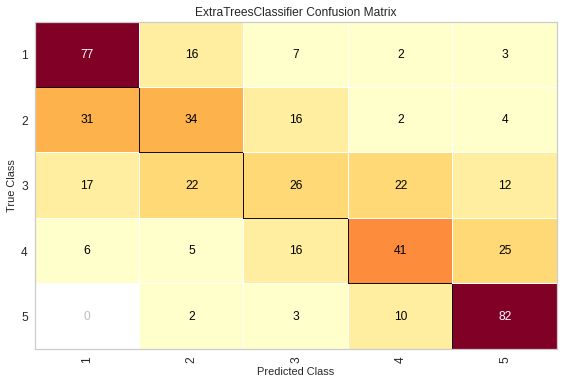

/home/hacciety/anaconda3/envs/dengue/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


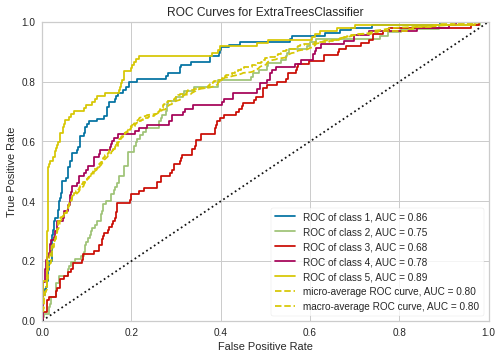

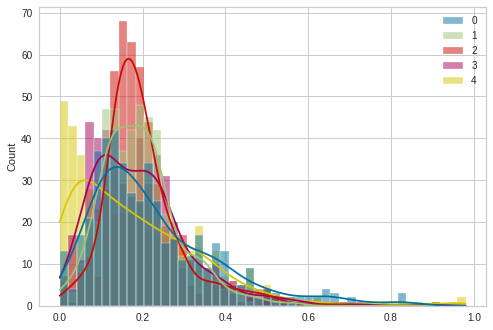

0.5405405405405406


In [41]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from yellowbrick.classifier import ConfusionMatrix, ROCAUC
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score

import xgboost as xgb

# Concatenate features here - [roll3, diff_features, roll7, double_diff_features, exp_roll]
dfs_to_join = [roll3, roll7, exp_roll]

X_train_ml_joined = X_train_ml.join(dfs_to_join).fillna(-999)

# Quick Splitting
X_tr, X_te, y_tr, y_te = train_test_split(X_train_ml_joined, 
                                          all_quantile_labels, test_size=0.33, random_state=42)


#ExtraTreesClassifier
ex_clf = ExtraTreesClassifier(n_estimators = 150,
                             max_depth = 10,
                             n_jobs = -1)


# XGB Estimator
#ex_clf = xgb.XGBClassifier(n_estimators = 500,
#                           max_depth = 3,
#                           learning_rate = 0.01,
#                           gamma = 10,
#                           objective = "multi:softprob")

def run_estimator_and_show():
    pass

ex_clf.fit(X_tr, y_tr)
preds = ex_clf.predict(X_te)


# Metrics
cm = ConfusionMatrix(ex_clf)
cm.fit(X_tr, y_tr)
cm.score(X_te, y_te)
cm.show()

rc = ROCAUC(ex_clf)
rc.fit(X_tr, y_tr)
rc.score(X_te, y_te)
rc.show()


pred_probabilities = ex_clf.predict_proba(X_te)
sns.histplot(pred_probabilities, kde = True)
plt.show()

print(accuracy_score(y_te, preds))

In [32]:
from tqdm import tqdm

ex_clf.fit(X_tr, y_tr)

r = permutation_importance(ex_clf, X_te, y_te,
                               n_repeats=30,
                               random_state=0,
                              n_jobs = -1)


In [33]:
perm_results = pd.DataFrame()
perm_results["feature_names"] = X_te.columns
perm_results['importance_mean'] = r.importances_mean
perm_results["importance_std"] = r.importances_std
# perm_results["importances"] = r.importances

perm_results.sort_values(by = "importance_mean", ascending = False)

,feature_names,importance_mean,importance_std
43,ndvi_ser7_max,0.020028,0.005718
42,ndvi_nwr7_max,0.017533,0.004822
44,ndvi_swr7_max,0.012821,0.005370
54,reanalysis_specific_humidity_g_per_kgr7_max,0.012474,0.006596
50,reanalysis_min_air_temp_kr7_max,0.011989,0.006136
38,station_max_temp_cr20_std,0.011781,0.005664
56,station_avg_temp_cr7_max,0.010534,0.005805
46,reanalysis_air_temp_kr7_max,0.010187,0.006222
52,reanalysis_relative_humidity_percentr7_max,0.009633,0.006340
48,reanalysis_dew_point_temp_kr7_max,0.009425,0.005334


In [34]:
perm_results.to_csv("../deng_output/permutation_importance_xgb.csv")

### Feature Selection Comparison

In [35]:
good_features = perm_results[perm_results.importance_mean > 0]
good_feature_list = list(good_features.feature_names)

0.5509355509355509


/home/hacciety/anaconda3/envs/dengue/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


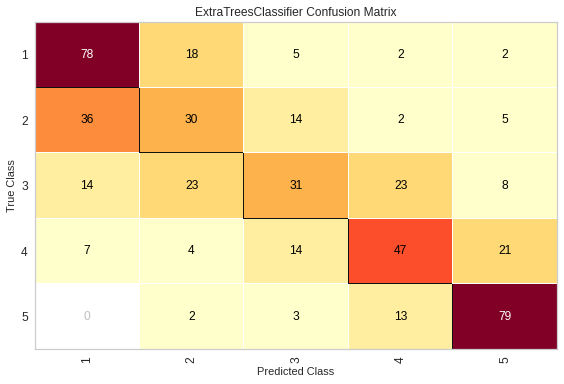

/home/hacciety/anaconda3/envs/dengue/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


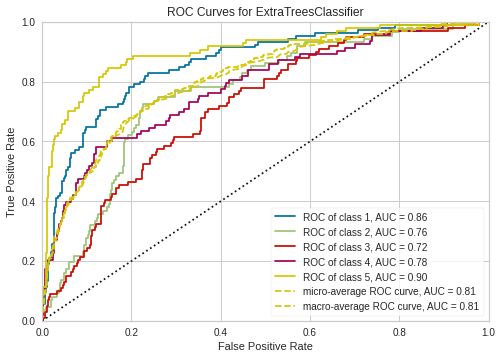

<AxesSubplot:title={'center':'ROC Curves for ExtraTreesClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [36]:
ex_clf.fit(X_tr[good_feature_list], y_tr)
preds = ex_clf.predict(X_te[good_feature_list])
print(accuracy_score(y_te, preds))

# Metrics
cm = ConfusionMatrix(ex_clf)
cm.fit(X_tr[good_feature_list], y_tr)
cm.score(X_te[good_feature_list], y_te)
cm.show()

rc = ROCAUC(ex_clf)
rc.fit(X_tr[good_feature_list], y_tr)
rc.score(X_te[good_feature_list], y_te)
rc.show()

## Compare Total Cases with City and week of year

<AxesSubplot:xlabel='weekofyear', ylabel='total_cases'>

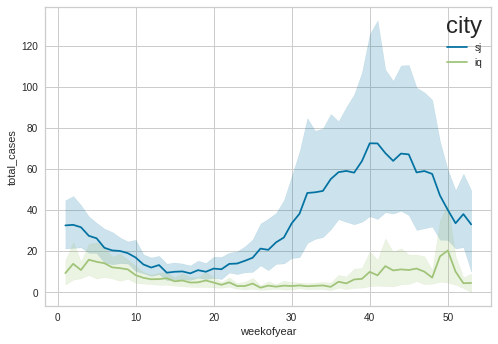

In [37]:
sns.lineplot(x = "weekofyear", y = "total_cases", hue = "city", data = full_train)

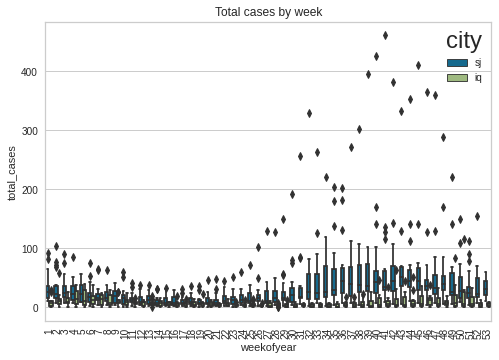

In [38]:
g = sns.boxplot(x = "weekofyear", y = "total_cases", hue = "city", data = full_train)
g.set_title("Total cases by week")
plt.xticks(rotation = 90)
plt.show()

## SJ: Do the higher quantile samples differ in the othe variables dramatically?

## IQ: Do the higher quantile samples differ in the othe variables dramatically?

## Do the higher values of SJ and IQ have a common signal beforehand?

## 